In [1475]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from sklearn.metrics import roc_auc_score
from scipy.stats import zscore

from sklearn.metrics import classification_report

In [1476]:
ar = pd.read_csv('data/application_record.zip', compression='zip')
cr = pd.read_csv('data/credit_record.zip', compression='zip')

In [1477]:
# общая информация о датасете
ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [1478]:
# количество уникальных ID (при общем количестве 438 557)
ar['ID'].nunique()

438510

In [1479]:
# избавляемся от дубликатов в исходном датафрейме
ar.drop_duplicates('ID', keep='last', inplace=True)
ar.shape

(438510, 18)

In [1480]:
# общая информация о датасете, содержащем данные о просрочках по кредиту
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [1481]:
# количество уникальных ID
cr['ID'].unique().size

45985

In [1482]:
# смотрим по каким признакам есть нулевые значения
ar.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134187
CNT_FAM_MEMBERS             0
dtype: int64

<AxesSubplot:>

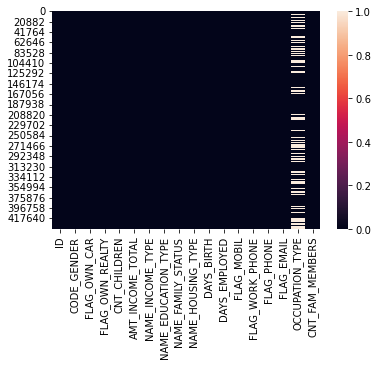

In [1483]:
# проверяем наличие нулевых значений с помощью визуализации
sns.heatmap(ar.isnull())

In [1484]:
# слишком много пропущенных значений в поле OCCUPATION_TYPE, избавляемся от него
ar.drop('OCCUPATION_TYPE', axis=1, inplace=True)

<AxesSubplot:>

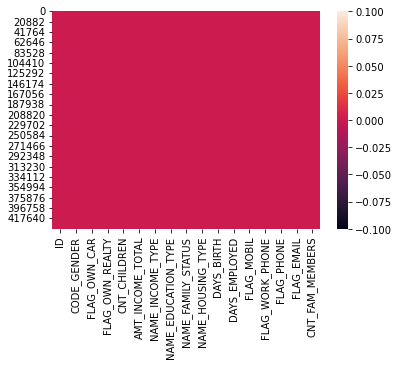

In [1485]:
# проверяем наличие нулевых значений с помощью визуализации
sns.heatmap(ar.isnull())

<AxesSubplot:>

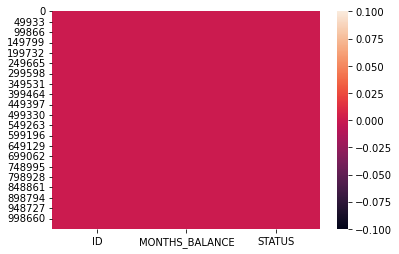

In [1486]:
# проверяем наличие нулевых значений с помощью визуализации
sns.heatmap(cr.isnull())

In [1487]:
variances = ar.select_dtypes(include=['number']).var()
print("Дисперсия признаков:\n", variances)

Дисперсия признаков:
 ID                  3.266080e+11
CNT_CHILDREN        5.254619e-01
AMT_INCOME_TOTAL    1.211777e+10
DAYS_BIRTH          1.751471e+07
DAYS_EMPLOYED       1.925612e+10
FLAG_MOBIL          0.000000e+00
FLAG_WORK_PHONE     1.636434e-01
FLAG_PHONE          2.049560e-01
FLAG_EMAIL          9.649516e-02
CNT_FAM_MEMBERS     8.049854e-01
dtype: float64


In [1488]:
# очень низкая дисперсия, избавляемся от него
ar.drop('FLAG_MOBIL', axis=1, inplace=True)

In [1489]:
cr['STATUS'].value_counts() 

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

- **0:** 1-29 days past due 
- **1:** 30-59 days past due 
- **2:** 60-89 days overdue 
- **3:** 90-119 days overdue 
- **4:** 120-149 days overdue 
- **5:** Overdue or bad debts, write-offs for more than 150 days 
- **C:** paid off that month 
- **X:** No loan for the month

In [1490]:
cr['STATUS'] = cr['STATUS'].replace({'C' : 0, 'X' : 0})
cr['STATUS'] = cr['STATUS'].astype(int)
cr['STATUS'].value_counts() 

0    1034381
1      11090
5       1693
2        868
3        320
4        223
Name: STATUS, dtype: int64

In [1491]:
overdue = cr.copy()


In [1492]:
overdue = overdue.groupby('ID').agg(max).reset_index()
overdue.drop('MONTHS_BALANCE', axis=1, inplace=True)
overdue

,ID,STATUS
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


In [1493]:
df = ar.join(overdue.set_index('ID'), on='ID', how='inner')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0,0


In [1494]:
# cr['STATUS'] = cr['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
# cr['STATUS'].value_counts() 

df['STATUS'] = df['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
df['STATUS'].value_counts() 

0    32166
1     4291
Name: STATUS, dtype: int64

In [1495]:
# # убираем поле с информацией о дате просрочки, оставляем только таргет
# cr = cr.groupby('ID').agg(max).reset_index()
# cr.drop('MONTHS_BALANCE', axis=1, inplace=True)
# cr

In [1496]:
# # объединяем в итоговом датафрейме признаки с таргетом
# df = ar.join(cr.set_index('ID'), on='ID', how='inner')
# df.head()

In [1497]:
# Вставляем доп.признак с количеством дней просрочки на предпоследнюю позицию
# df.insert(len(df.columns) - 1, 'OVERDUE', df['STATUS'])

# df['OVERDUE'].value_counts()

In [1498]:
# df['STATUS'].value_counts() 

In [1499]:
# df['STATUS'] = df['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
# df['STATUS'].value_counts() 

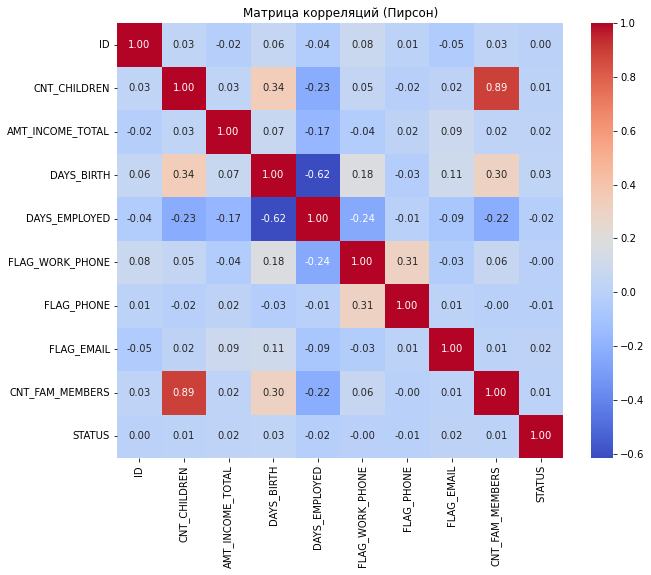

In [1500]:
# Вычисление матрицы корреляций
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций (Пирсон)')
plt.show()

In [1501]:
correlation_results = []

# Проходим по всем числовым признакам
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'target':
        pearson_corr, _ = pearsonr(df[col], df['STATUS'])
        spearman_corr, _ = spearmanr(df[col], df['STATUS'])
        correlation_results.append((col, pearson_corr, spearman_corr))

# Создаем DataFrame с результатами
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Pearson', 'Spearman'])
print(correlation_df.sort_values(by='Pearson', ascending=False))

            Feature   Pearson  Spearman
9            STATUS  1.000000  1.000000
3        DAYS_BIRTH  0.028943  0.029429
2  AMT_INCOME_TOTAL  0.024202  0.016408
7        FLAG_EMAIL  0.019658  0.019658
1      CNT_CHILDREN  0.011525  0.007000
8   CNT_FAM_MEMBERS  0.009004  0.005026
0                ID  0.003565  0.004818
5   FLAG_WORK_PHONE -0.000149 -0.000149
6        FLAG_PHONE -0.006355 -0.006355
4     DAYS_EMPLOYED -0.021566 -0.009253


In [1502]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# vif_data = pd.DataFrame()
# vif_data['Feature'] = df.columns
# vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
# print(vif_data)
# VIF > 5 или 10 указывает на сильную мультиколлинеарность.

In [1503]:
# df.drop('CNT_FAM_MEMBERS', axis=1, inplace=True)
df.drop('CNT_CHILDREN', axis=1, inplace=True)
df.drop('NAME_FAMILY_STATUS', axis=1, inplace=True)
df.drop('NAME_EDUCATION_TYPE', axis=1, inplace=True)
# df.drop('DAYS_BIRTH', axis=1, inplace=True)
df.drop('DAYS_EMPLOYED', axis=1, inplace=True)
# df.drop('CODE_GENDER', axis=1, inplace=True)
# df.drop('FLAG_PHONE', axis=1, inplace=True)
# df.drop('FLAG_WORK_PHONE', axis=1, inplace=True)
# df.drop('FLAG_EMAIL', axis=1, inplace=True)

В соответствии с типом признака (номинальный или порядковым) и количеством уникальных значений определим каким образом будем кодировать категориальные переменные.

In [1504]:
# смотрим типы данных
df.dtypes

ID                     int64
CODE_GENDER           object
FLAG_OWN_CAR          object
FLAG_OWN_REALTY       object
AMT_INCOME_TOTAL     float64
NAME_INCOME_TYPE      object
NAME_HOUSING_TYPE     object
DAYS_BIRTH             int64
FLAG_WORK_PHONE        int64
FLAG_PHONE             int64
FLAG_EMAIL             int64
CNT_FAM_MEMBERS      float64
STATUS                 int64
dtype: object

In [1505]:
object_type = pd.DataFrame(df.dtypes =='object').reset_index()
object_type = object_type[object_type[0] == True]['index']
object_type

1          CODE_GENDER
2         FLAG_OWN_CAR
3      FLAG_OWN_REALTY
5     NAME_INCOME_TYPE
6    NAME_HOUSING_TYPE
Name: index, dtype: object

In [1506]:
df['FLAG_OWN_CAR'].value_counts() # binary encoder

N    22614
Y    13843
Name: FLAG_OWN_CAR, dtype: int64

In [1507]:
df['FLAG_OWN_REALTY'].value_counts()

Y    24506
N    11951
Name: FLAG_OWN_REALTY, dtype: int64

In [1508]:
df['NAME_INCOME_TYPE'].value_counts() # не все значения одинаково часто встречаются, TargetEncoding не подойдет, но порядковый - LabelEncoding

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64

In [1509]:
df['NAME_HOUSING_TYPE'].value_counts() # не все значения одинаково часто встречаются, target encoding не подойдет -> BinaryEncoding

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: NAME_HOUSING_TYPE, dtype: int64

In [1510]:
# попробуем просто заменить на 0 и 1
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace({'Y' : 1, 'N' : 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace({'Y' : 1, 'N' : 0})
df['CODE_GENDER'] = df['CODE_GENDER'].replace({'F' : 1, 'M' : 0})

In [1511]:
#  кодируем категориальный порядковый признак
le = LabelEncoder()
df['NAME_INCOME_TYPE'] = le.fit_transform(df['NAME_INCOME_TYPE'])
df['NAME_HOUSING_TYPE'] = le.fit_transform(df['NAME_HOUSING_TYPE'])
# df['NAME_EDUCATION_TYPE'] = le.fit_transform(df['NAME_EDUCATION_TYPE'])

In [1512]:
# mean_encoding = df.groupby('NAME_FAMILY_STATUS')['STATUS'].mean()
# df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].map(mean_encoding)

In [1513]:
# смотрим типы данных
df.dtypes

ID                     int64
CODE_GENDER            int64
FLAG_OWN_CAR           int64
FLAG_OWN_REALTY        int64
AMT_INCOME_TOTAL     float64
NAME_INCOME_TYPE       int32
NAME_HOUSING_TYPE      int32
DAYS_BIRTH             int64
FLAG_WORK_PHONE        int64
FLAG_PHONE             int64
FLAG_EMAIL             int64
CNT_FAM_MEMBERS      float64
STATUS                 int64
dtype: object

In [1514]:
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
0,5008804,0,1,1,427500.0,4,4,-12005,1,0,0,2.0,1
1,5008805,0,1,1,427500.0,4,4,-12005,1,0,0,2.0,1
2,5008806,0,1,1,112500.0,4,1,-21474,0,0,0,2.0,0
3,5008808,1,0,1,270000.0,0,1,-19110,0,1,1,1.0,0
4,5008809,1,0,1,270000.0,0,1,-19110,0,1,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,0,1,1,315000.0,4,1,-17348,0,0,0,2.0,1
434809,5149834,1,0,1,157500.0,0,1,-12387,0,1,1,2.0,1
434810,5149838,1,0,1,157500.0,1,1,-12387,0,1,1,2.0,1
434811,5150049,1,0,1,283500.0,4,1,-17958,0,0,0,2.0,1


In [1515]:
df['STATUS'].value_counts()

0    32166
1     4291
Name: STATUS, dtype: int64

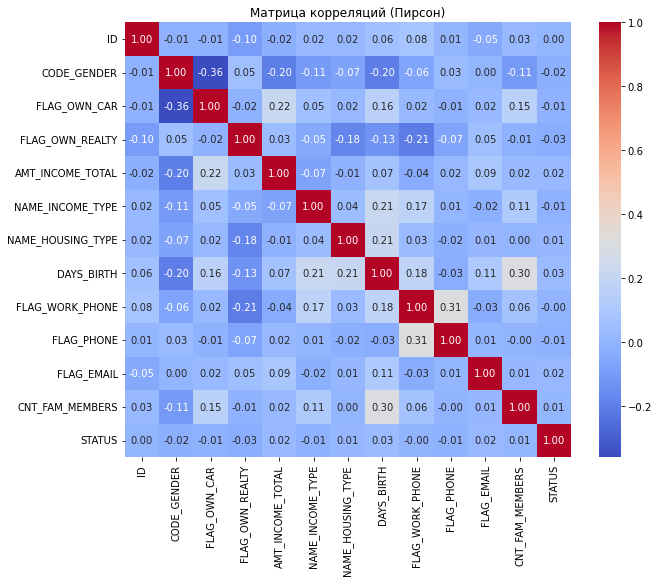

In [1516]:
# Вычисление матрицы корреляций
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций (Пирсон)')
plt.show()

In [1517]:
correlation_results = []

# Проходим по всем числовым признакам
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'target':
        pearson_corr, _ = pearsonr(df[col], df['STATUS'])
        spearman_corr, _ = spearmanr(df[col], df['STATUS'])
        correlation_results.append((col, pearson_corr, spearman_corr))

# Создаем DataFrame с результатами
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Pearson', 'Spearman'])
print(correlation_df.sort_values(by='Pearson', ascending=False))

             Feature   Pearson  Spearman
10            STATUS  1.000000  1.000000
5         DAYS_BIRTH  0.028943  0.029429
4   AMT_INCOME_TOTAL  0.024202  0.016408
8         FLAG_EMAIL  0.019658  0.019658
9    CNT_FAM_MEMBERS  0.009004  0.005026
0                 ID  0.003565  0.004818
6    FLAG_WORK_PHONE -0.000149 -0.000149
7         FLAG_PHONE -0.006355 -0.006355
2       FLAG_OWN_CAR -0.010580 -0.010580
1        CODE_GENDER -0.021257 -0.021257
3    FLAG_OWN_REALTY -0.027990 -0.027990


In [1518]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# vif_data = pd.DataFrame()
# vif_data['Feature'] = df.columns
# vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
# print(vif_data)
# VIF > 5 или 10 указывает на сильную мультиколлинеарность.

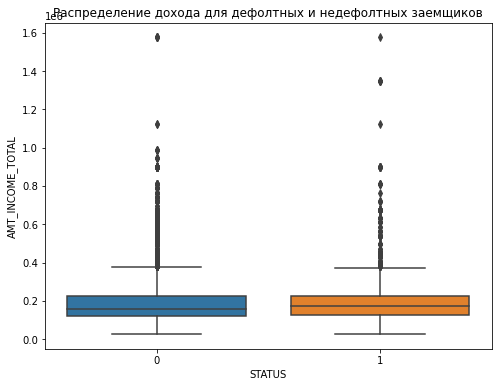

In [1519]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='STATUS', y='AMT_INCOME_TOTAL', data=df)
plt.title('Распределение дохода для дефолтных и недефолтных заемщиков')
plt.show()

In [1520]:
# # проверяем наличие выбросов с помощью визуализации

# fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,10))
# sns.scatterplot(x=df['ID'], y=df['FLAG_OWN_CAR'], data=df, ax=ax[0][0])
# sns.scatterplot(x=df['ID'], y=df['FLAG_OWN_REALTY'], data=df, ax=ax[0][1])
# sns.scatterplot(x=df['ID'], y=df['AMT_INCOME_TOTAL'], data=df, ax=ax[0][2])

# sns.scatterplot(x=df['ID'], y=df['NAME_INCOME_TYPE'], data=df, ax=ax[1][0])
# sns.scatterplot(x=df['ID'], y=df['NAME_HOUSING_TYPE'], data=df, ax=ax[1][1])
# sns.scatterplot(x=df['ID'], y=df['FLAG_WORK_PHONE'], data=df, ax=ax[1][2])

# sns.scatterplot(x=df['ID'], y=df['FLAG_PHONE'], data=df, ax=ax[2][0])
# sns.scatterplot(x=df['ID'], y=df['FLAG_EMAIL'], data=df, ax=ax[2][1])

In [1521]:
# # Вычисляем Z-оценки и удаляем выбросы (|Z| > 3)
# df['z_score'] = zscore(df['AMT_INCOME_TOTAL'])
# df = df[np.abs(df['z_score']) <= 3]

In [1522]:
# # Вычисляем Z-оценки и удаляем выбросы (|Z| > 3)
# df['z_score'] = zscore(df['NAME_INCOME_TYPE'])
# df = df[np.abs(df['z_score']) <= 3]

In [1523]:
# # проверяем наличие выбросов с помощью визуализации после очистки

# fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,10))
# sns.scatterplot(x=df['ID'], y=df['FLAG_OWN_CAR'], data=df, ax=ax[0][0])
# sns.scatterplot(x=df['ID'], y=df['FLAG_OWN_REALTY'], data=df, ax=ax[0][1])
# sns.scatterplot(x=df['ID'], y=df['AMT_INCOME_TOTAL'], data=df, ax=ax[0][2])

# sns.scatterplot(x=df['ID'], y=df['NAME_INCOME_TYPE'], data=df, ax=ax[1][0])
# sns.scatterplot(x=df['ID'], y=df['NAME_HOUSING_TYPE'], data=df, ax=ax[1][1])
# sns.scatterplot(x=df['ID'], y=df['FLAG_WORK_PHONE'], data=df, ax=ax[1][2])

# sns.scatterplot(x=df['ID'], y=df['FLAG_PHONE'], data=df, ax=ax[2][0])
# sns.scatterplot(x=df['ID'], y=df['FLAG_EMAIL'], data=df, ax=ax[2][1])

In [1524]:
# генерация признаков + PSI 

In [1525]:
df['DAYS_BIRTH'] = - (df['DAYS_BIRTH'] // 365)
df['DAYS_BIRTH']

0         33
1         33
2         59
3         53
4         53
          ..
434808    48
434809    34
434810    34
434811    50
434812    26
Name: DAYS_BIRTH, Length: 36457, dtype: int64

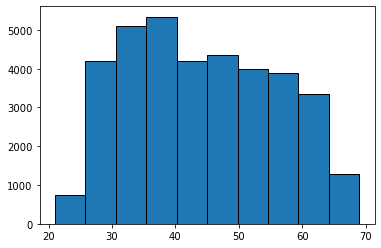

In [1526]:
plt.hist(df['DAYS_BIRTH'], bins=10, edgecolor='black')
plt.show()

In [1527]:
# Определяем границы бинов
bins = [20, 30, 40, 50, 60, 100]

# Создаем метки для бинов
labels = ['21-30', '31-40', '41-50', '51-60', '60+']

# Разбиваем возраст на бины
df['DAYS_BIRTH'] = pd.cut(df['DAYS_BIRTH'], bins=bins, labels=labels, right=False)

In [1528]:
df['DAYS_BIRTH'].value_counts()

31-40    10258
41-50     9670
51-60     7889
60+       4638
21-30     4002
Name: DAYS_BIRTH, dtype: int64

In [1529]:
mean_encoding = df.groupby('DAYS_BIRTH')['STATUS'].mean()
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].map(mean_encoding)

In [1530]:
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
0,5008804,0,1,1,427500.0,4,4,0.127998,1,0,0,2.0,1
1,5008805,0,1,1,427500.0,4,4,0.127998,1,0,0,2.0,1
2,5008806,0,1,1,112500.0,4,1,0.113703,0,0,0,2.0,0
3,5008808,1,0,1,270000.0,0,1,0.113703,0,1,1,1.0,0
4,5008809,1,0,1,270000.0,0,1,0.113703,0,1,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,0,1,1,315000.0,4,1,0.109721,0,0,0,2.0,1
434809,5149834,1,0,1,157500.0,0,1,0.127998,0,1,1,2.0,1
434810,5149838,1,0,1,157500.0,1,1,0.127998,0,1,1,2.0,1
434811,5150049,1,0,1,283500.0,4,1,0.113703,0,0,0,2.0,1


In [1531]:
X = df.iloc[:,1:-1]  # с конца убираем таргет 
y = df['STATUS']

In [1532]:
# делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1533]:
# приводим признаки к одной шкале, RobustScaler не чувствителен к выбросам в отличие от MinMaxScaler()
rs = RobustScaler()
X_scaled = pd.DataFrame(rs.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(rs.transform(X_test), columns=X_test.columns)

In [1534]:
# # приводим признаки к одной шкале, MinMaxScaler() чувствителен к выбросам 
# rs = MinMaxScaler()
# X_scaled = pd.DataFrame(rs.fit_transform(X_train), columns=X_train.columns)
# X_test_scaled = pd.DataFrame(rs.transform(X_test), columns=X_test.columns)

In [1535]:
X_scaled

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,-1.0,1.0,0.0,-0.217391,0.000000,4.0,-0.217862,0.0,0.0,0.0,0.0
1,0.0,1.0,-1.0,-0.217391,-1.333333,0.0,1.147901,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.217391,-1.333333,0.0,0.782138,0.0,0.0,0.0,2.0
3,0.0,1.0,0.0,1.956522,-1.333333,0.0,0.000000,0.0,0.0,1.0,-1.0
4,0.0,0.0,-1.0,1.086957,0.000000,0.0,-0.217862,0.0,1.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
29160,0.0,0.0,0.0,-0.434783,-1.000000,0.0,-0.546818,0.0,1.0,1.0,-1.0
29161,0.0,0.0,0.0,-0.217391,-1.333333,0.0,-0.217862,0.0,0.0,0.0,1.0
29162,0.0,0.0,0.0,-0.782609,0.000000,0.0,-0.217862,1.0,1.0,0.0,0.0
29163,0.0,0.0,0.0,0.000000,-1.000000,0.0,-0.546818,0.0,1.0,0.0,0.0


In [1536]:
y_train.value_counts()

0    25746
1     3419
Name: STATUS, dtype: int64

In [1537]:
oversample = SMOTE() # Synthetic Minority Over-sampling Technique
X_balanced, y_balanced = oversample.fit_resample(X_scaled, y_train)

In [1538]:
y_balanced.value_counts()

1    25746
0    25746
Name: STATUS, dtype: int64

In [1539]:
# def calculate_psi(expected, actual, bins=10, epsilon=1e-6):
#     # Разбиваем данные на бины
#     breakpoints = np.histogram_bin_edges(expected, bins=bins)
#     expected_counts, _ = np.histogram(expected, bins=breakpoints)
#     actual_counts, _ = np.histogram(actual, bins=breakpoints)
    
#     # Добавляем epsilon, чтобы избежать деления на ноль
#     expected_counts = expected_counts + epsilon
#     actual_counts = actual_counts + epsilon
    
#     # Нормализуем до процентов
#     expected_percents = expected_counts / np.sum(expected_counts)
#     actual_percents = actual_counts / np.sum(actual_counts)
    
#     # Рассчитываем PSI
#     psi = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
    
#     return psi

# def calculate_psi_for_dataframe(df_expected, df_actual, bins=10):
#     psi_results = {}
    
#     for column in df_expected.columns:
#         expected = df_expected[column]
#         actual = df_actual[column]
#         psi_value = calculate_psi(expected, actual, bins=bins)
#         psi_results[column] = psi_value
    
#     return psi_results

In [1540]:
# # Рассчитываем PSI для всех признаков
# psi_results = calculate_psi_for_dataframe(X_balanced, X_test_balanced, bins=10)

# # Выводим результаты
# for feature, psi in psi_results.items():
#     print(f"PSI для признака {feature}: {psi:.4f}")

In [1541]:
# classifiers = {
#     "LogisticRegression" : LogisticRegression(max_iter=1000),
#     "KNeighbors" : KNeighborsClassifier(),
#     "SVC" : SVC(),
#     "DecisionTree" : DecisionTreeClassifier(),
#     "RandomForest" : RandomForestClassifier(),
#     "XGBoost" : XGBClassifier()
# }

In [1542]:
# train_scores = []
# test_scores = []

# for key, classifier in classifiers.items():
#     classifier.fit(X_balanced, y_balanced)
#     train_score = classifier.score(X_balanced, y_balanced)
#     train_scores.append(train_score)
#     test_score = classifier.score(X_test, y_test)
#     test_scores.append(test_score)

# print(train_scores)
# print(test_scores)

In [1543]:
xgb = XGBClassifier()
model = xgb.fit(X_balanced, y_balanced)
train_score = xgb.score(X_balanced, y_balanced)
test_score = xgb.score(X_test, y_test)
xgb_prediction = xgb.predict(X_test)

print(f"xgb train score = {train_score}")
print(f"xgb test score = {test_score}")

xgb train score = 0.8288083585799736
xgb test score = 0.7084476138233681


In [1544]:
print(classification_report(y_test, xgb_prediction)) #1 xgb

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      6420
           1       0.13      0.26      0.18       872

    accuracy                           0.71      7292
   macro avg       0.51      0.52      0.50      7292
weighted avg       0.79      0.71      0.75      7292



In [1545]:
# Вычисляем AUC
auc = roc_auc_score(y_test, xgb_prediction)

# Вычисляем коэффициент Джини
gini = 2 * auc - 1
print(f"xgb AUC: {auc}")
print(f"xgb Gini: {gini}")

xgb AUC: 0.5153133842064649
xgb Gini: 0.030626768412929772


In [1546]:
cm = confusion_matrix(y_test, xgb_prediction)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[4938 1482]
 [ 644  228]]


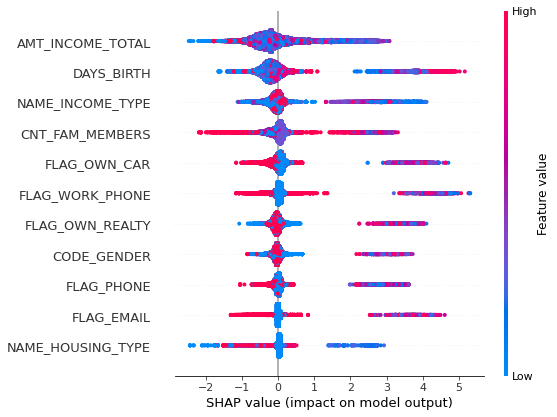

In [1547]:
import shap

# Создание explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_balanced)

# Визуализация значимости признаков
shap.summary_plot(shap_values, X_balanced, feature_names=X_balanced.columns)

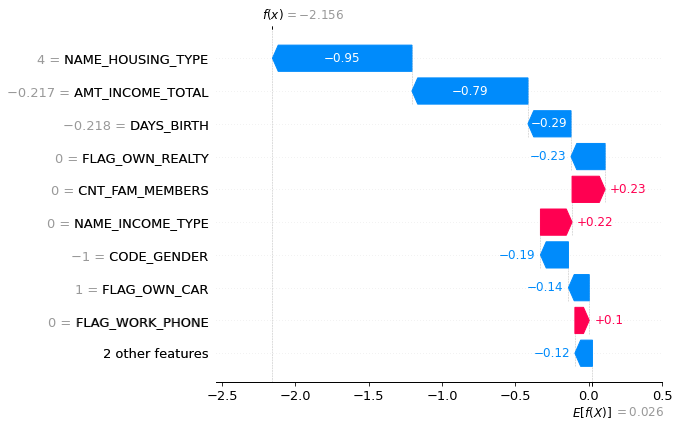

In [1548]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_balanced)
shap.plots.waterfall(shap_values[0])

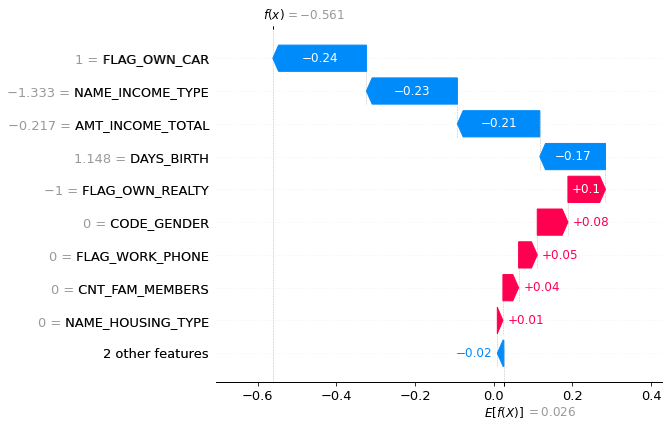

In [1549]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_balanced)
shap.plots.waterfall(shap_values[1])

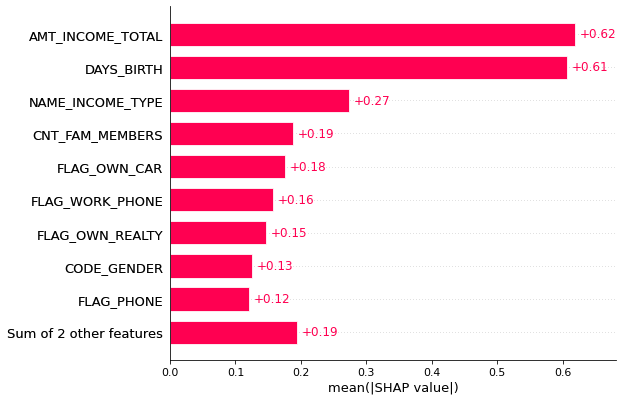

In [1550]:
shap.plots.bar(shap_values)

In [1551]:
logreg = LogisticRegression(max_iter=1000)
model = logreg.fit(X_balanced, y_balanced)
train_score = logreg.score(X_balanced, y_balanced)
test_score = logreg.score(X_test, y_test)
logreg_prediction = logreg.predict(X_test)

print(f"logreg train score = {train_score}")
print(f"logreg test score = {test_score}")

logreg train score = 0.5370931406820477
logreg test score = 0.11958310477235326


In [1552]:
print(classification_report(y_test, logreg_prediction)) #logreg

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6420
           1       0.12      1.00      0.21       872

    accuracy                           0.12      7292
   macro avg       0.06      0.50      0.11      7292
weighted avg       0.01      0.12      0.03      7292



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1553]:
# Вычисляем AUC
auc = roc_auc_score(y_test, logreg_prediction)

# Вычисляем коэффициент Джини
gini = 2 * auc - 1
print(f"logreg AUC: {auc}")
print(f"logreg Gini: {gini}")

logreg AUC: 0.5
logreg Gini: 0.0
